# US Wildfires 1992 - 2015
### An analysis of climate trends and wildfire causes

The following Notebook contains an analysis of 1.88 million US wildfire records spanning 1992-2015. The following are questions and ideas that will be explored:

    - Has wildfire activity seen an increase year over year in the given time span?
    - Has wildfire severity increased year over year?
    - What are the trends of Wildfire causes and how has that changed over time?
    - What is the most frequent reported cause?
    - How does geographic location of wildfire correlate to severity and causes?
    - What is the climatic impact to wildfires over time?
    - Finally what ML models and variables can we employ to help predict causes of wildfires and/or severity of wildfires?

The dataset for wildfires comes in a neatly packaged sqlite database originally sourced from an aggregated dataset provided by data.gov

Daily climate summary data is sourced from the Global Historical Climate Network provided by NOAA and GHCN. This set is a little more raw and will take some significant clean up in order to make it usable and pairable with the wildfire dataset.

In order to join climate data with the wildfire dataset, metadata about weather stations will first need to be analyzed. The Haversine Distance Formula will be used to determine the weather station nearest to each fires lat/long origin.

Both SQL and Python will be used for data exploration as well as my SQL client software of choice, DBeaver.



    

In [101]:
%matplotlib inline
import sqlite3 as sql
import pandas as pd
import numpy as np
import re
import time
import random
import datetime
import matplotlib.pyplot as plt
import statistics
import json
from colorama import Fore, Back, Style
from math import radians, cos, sin, asin, sqrt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import seaborn
from IPython.display import Image

![Fires Table Structure](./fires_structure.png)

### Dates are going to be an important factor. Lets Look at sqlite documentation for the data type REALDATE

SQLite does not have a storage class set aside for storing dates and/or times. Instead,the built-in Date And Time Functions of SQLite are capable of storing dates and times as TEXT, REAL, or INTEGER values:

- TEXT as ISO8601 strings ("YYYY-MM-DD HH:MM:SS.SSS").
- REAL as Julian day numbers, the number of days since noon in Greenwich on November 24, 4714 B.C. according to the proleptic Gregorian calendar.
- INTEGER as Unix Time, the number of seconds since 1970-01-01 00:00:00 UTC. 

Applications can chose to store dates and times in any of these formats and freely convert between formats using the built-in date and time functions.

Sounds to me these dates fall under the REAL type with a custom datatype name. So it is Julian Dates.



In [2]:
# Query and load data into Pandas DataFrame
#conn = sql.connect('./FPA_FOD_20170508.sqlite')

#wf_data = pd.read_sql_query(f"SELECT * FROM 'Fires'", conn)

#wf_data.head()

#conn.close()

### Turns out all 1.9 million records are a bit overkill. Lets get this dataset down to a more manageable size. From here there will be a focus on only fires that are Size class C - G. That is any fire which the containment perimeter was 10+ acres.

In [3]:
# get only the columns needed for analysis
conn = sql.connect('./FPA_FOD_20170508.sqlite')

wf_data = pd.read_sql_query(f"""
SELECT OBJECTID, NWCG_REPORTING_UNIT_ID, NWCG_REPORTING_UNIT_NAME, FIRE_NAME,
STATE, LATITUDE, LONGITUDE, FIRE_YEAR, DATE(DISCOVERY_DATE) AS DISCOVERY_DATE, DISCOVERY_TIME, STAT_CAUSE_CODE, STAT_CAUSE_DESCR,
DATE(CONT_DATE) AS CONT_DATE, CONT_TIME, FIRE_SIZE, FIRE_SIZE_CLASS
FROM Fires 
WHERE FIRE_SIZE_CLASS != 'A' AND FIRE_SIZE_CLASS != 'B' AND STATE != 'PR' ORDER BY OBJECTID""", conn)

display(wf_data.head())
display(wf_data.tail())

,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS
0,17,USCAENF,Eldorado National Forest,POWER,CA,38.523333,-120.211667,2004,2004-10-06,1415,2.0,Equipment Use,2004-10-21,1000,16823.0,G
1,18,USCAENF,Eldorado National Forest,FREDS,CA,38.780000,-120.260000,2004,2004-10-13,1618,2.0,Equipment Use,2004-10-17,1800,7700.0,G
2,26,USNMLNF,Lincoln National Forest,BACHELOR,NM,33.315833,-105.512222,2004,2004-07-20,1405,1.0,Lightning,2004-07-20,1600,10.0,C
3,38,USNCNCF,National Forests in North Carolina,HOWARD GAP,NC,35.000278,-83.351111,2005,2005-01-27,2200,7.0,Arson,2005-01-28,0300,50.3,C
4,40,USNCNCF,National Forests in North Carolina,AUSTIN CREEK,NC,36.001667,-81.590000,2005,2005-02-12,1520,5.0,Debris Burning,2005-02-13,0330,125.0,D


,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS
271416,1880388,USCAMEU,Mendocino Unit,SODA,CA,39.045908,-123.265522,2015,2015-07-04,1525,9.0,Miscellaneous,2015-07-04,2022,24.0,C
271417,1880400,USCARRU,Riverside Unit,GILMAN,CA,33.892120,-117.079065,2009,2009-05-03,1208,13.0,Missing/Undefined,2009-05-03,1358,73.0,C
271418,1880412,USCATUU,Tulare Unit,TERRA,CA,35.985512,-118.915364,2009,2009-06-19,1802,9.0,Miscellaneous,2009-06-19,1832,23.0,C
271419,1880420,USCAMVU,Monte Vista Unit,SLAUGHTERHOUSE,CA,32.906591,-116.942448,2010,2010-05-29,1201,13.0,Missing/Undefined,None,None,50.0,C
271420,1880442,USCALAC,Los Angeles County Fire Department,None,CA,34.450000,-118.583333,2015,2015-12-07,1512,9.0,Miscellaneous,None,None,11.0,C


In [4]:
# get truncated version of above query for testing while building formulas and optimization
conn = sql.connect('./FPA_FOD_20170508.sqlite')

wf_data_trunc = pd.read_sql_query(f"""
SELECT OBJECTID, NWCG_REPORTING_UNIT_ID, NWCG_REPORTING_UNIT_NAME, FIRE_NAME,
STATE, LATITUDE, LONGITUDE, FIRE_YEAR, DATE(DISCOVERY_DATE) AS DISCOVERY_DATE, DISCOVERY_TIME, STAT_CAUSE_CODE, STAT_CAUSE_DESCR,
DATE(CONT_DATE) AS CONT_DATE, CONT_TIME, FIRE_SIZE, FIRE_SIZE_CLASS
FROM Fires 
WHERE FIRE_SIZE_CLASS != 'A' AND FIRE_SIZE_CLASS != 'B' AND STATE != 'PR' ORDER BY OBJECTID LIMIT 1000""", conn)

display(wf_data_trunc.head())
display(wf_data_trunc.tail())

,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS
0,17,USCAENF,Eldorado National Forest,POWER,CA,38.523333,-120.211667,2004,2004-10-06,1415,2.0,Equipment Use,2004-10-21,1000,16823.0,G
1,18,USCAENF,Eldorado National Forest,FREDS,CA,38.780000,-120.260000,2004,2004-10-13,1618,2.0,Equipment Use,2004-10-17,1800,7700.0,G
2,26,USNMLNF,Lincoln National Forest,BACHELOR,NM,33.315833,-105.512222,2004,2004-07-20,1405,1.0,Lightning,2004-07-20,1600,10.0,C
3,38,USNCNCF,National Forests in North Carolina,HOWARD GAP,NC,35.000278,-83.351111,2005,2005-01-27,2200,7.0,Arson,2005-01-28,0300,50.3,C
4,40,USNCNCF,National Forests in North Carolina,AUSTIN CREEK,NC,36.001667,-81.590000,2005,2005-02-12,1520,5.0,Debris Burning,2005-02-13,0330,125.0,D


,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS
995,7415,USAROUF,Ouachita National Forest,SHANIA,OK,34.869167,-94.877500,2006,2006-04-11,1645,7.0,Arson,2006-04-11,1930,18.00,C
996,7417,USGACHF,Chattahoochee-Oconee National Forest,PIKE,GA,34.554722,-85.091111,2006,2006-04-15,2000,7.0,Arson,2006-04-16,1730,25.00,C
997,7419,USGACHF,Chattahoochee-Oconee National Forest,SMITH GAP,GA,34.650833,-85.216389,2006,2006-04-17,1745,5.0,Debris Burning,2006-04-19,1800,13.00,C
998,7430,USMSMNF,National Forests in Mississippi,GAME WARDEN,MS,30.845278,-88.980833,2006,2006-02-24,1700,5.0,Debris Burning,2006-02-27,1240,14.45,C
999,7431,USMSMNF,National Forests in Mississippi,LITTLE BANG BAYOU,MS,30.542778,-88.871667,2006,2006-02-24,1659,5.0,Debris Burning,2006-02-25,1141,40.00,C


## Time to Explore and make the station data usable.
### The goal is to assign a weather station code to each Wildfire record.

The Stations file is not a delimited file, however each line is a fixed width of characters. This should be turned into a CSV or matrix. From there a table can potentially be created in the sqlite DB so proper relationships can be set. This will also provide a good structure to run the Haversine Distance Equation against. 

In [5]:
def reindex_names_states(lst):
    lst.append(lst[4])
    lst[4] = 'NULL'
    return lst

def read_stations(file):
    stations_list = []
    regex = re.compile("[\',]")
    with open(file, 'r+') as stations:
        for line in stations:
            state = 'NULL' if line[38:40].strip() == '' else line[38:40].strip()
            name = regex.sub(r'', line[41:71].strip())
            gsn = 'NULL' if line[71:75].strip() == '' else line[71:75].strip()
            hcn = 'NULL' if line[75:79].strip() == '' else line[75:79].strip()
            wmo = 'NULL' if line[79:85].strip() == '' else line[79:85].strip()
            station = ','.join(line[:37].split()) + ',' + ','.join([state, name, gsn, hcn, wmo])
            station = station.split(',')
            stations_list.append(station)
    return stations_list

stations = read_stations('ghcnd-stations.txt')



In [6]:
# create a new table and insert the station data

create_stations_sql = """CREATE TABLE IF NOT EXISTS WeatherStations (
                            stationid TEXT PRIMARY KEY,
                            latitude FLOAT64,
                            longitude FLOAT64, 
                            elevation FLOAT64, 
                            state TEXT, 
                            name TEXT,
                            gsn INT16,
                            hcn INT16,
                            wmoid INT32
                            );"""

def create_table(con, create_sql):
    try:
        curs = con.cursor()
        curs.execute(create_sql)
    except Exception as e:
        print(e)
        raise Exception(e)

def insert_stations(con, stations):
    try:
        curs = con.cursor()
        for station in stations:
            insert_sql = f"""INSERT INTO WeatherStations
                            VALUES ('{station[0]}', {float(station[1])}, 
                            {float(station[2])}, {float(station[3])},
                            {station[4] if station[4] == 'NULL' else "'"+station[4]+"'"},
                            '{station[5]}',
                            {0 if station[6] == 'NULL' else 1},
                            {0 if station[7] == 'NULL' else 1},
                            {station[8]}
                            );
                        """
            curs.execute(insert_sql)
    except Exception as e:
        print(e)

create_table(conn, create_stations_sql)
insert_stations(conn, stations)


UNIQUE constraint failed: WeatherStations.stationid


In [7]:
conn.commit()
conn.close()

## Let's check our newly created table in DBeaver to make sure the creation and inserts are correct.

![stations-loaded](./stations-loaded.png)

### All 118,492 global weather stations have been loaded in the Weather Stations table. Now it's time to use the Haversine Distance Equation to determine which station is closest to each wildfire's origin coordinates.


#### Each daily weather summary file contains a single station's historical data. Each file's name is the station id. Since we are only concerned about weather stations in the US, we only need to load a dataframe with the weather stations that are part of the US Historical Climate Network.

In [8]:
conn = sql.connect('./FPA_FOD_20170508.sqlite')

ws_data = pd.read_sql_query(f"SELECT * FROM 'WeatherStations' WHERE hcn = 1 AND stationid LIKE 'US%' AND state != 'PR'", conn)

conn.close()

display(ws_data.head())
display(ws_data.tail())

,stationid,latitude,longitude,elevation,state,name,gsn,hcn,wmoid
0,USC00011084,31.0583,-87.0550,25.9,AL,BREWTON 3 SSE,0,1,NaN
1,USC00012813,30.5467,-87.8808,7.0,AL,FAIRHOPE 2 NE,0,1,NaN
2,USC00013160,32.8347,-88.1342,38.1,AL,GAINESVILLE LOCK,0,1,NaN
3,USC00013511,32.6922,-87.5761,75.9,AL,GREENSBORO,0,1,NaN
4,USC00013816,31.8814,-86.2503,132.0,AL,HIGHLAND HOME,0,1,NaN


,stationid,latitude,longitude,elevation,state,name,gsn,hcn,wmoid
1213,USW00094224,46.1569,-123.8825,2.7,OR,ASTORIA RGNL AP,0,1,72791.0
1214,USW00094728,40.7789,-73.9692,39.6,NY,NEW YORK CNTRL PK TWR,0,1,72506.0
1215,USW00094793,41.1667,-71.5833,33.5,RI,BLOCK ISLAND STATE AP,0,1,NaN
1216,USW00094794,43.1450,-75.3839,216.7,NY,UTICA ONEIDA CO AP,0,1,NaN
1217,USW00094967,46.9006,-95.0678,437.1,MN,PARK RAPIDS MUNI AP,0,1,NaN


## Making Copies of the sample WF dataframe
### This is to test different methods of applying the haversine equation.

In [9]:
wf_data_trunc_2 = wf_data_trunc.copy(deep=True)
wf_data_trunc_3 = wf_data_trunc.copy(deep=True)

### Looking in the ghcnd_hcn directory there are 1219 files. The query above returned 1218 zero based index rows. It appears that all relevant weather stations in the ws_data DF have been loaded.

In [10]:
with open('neighbor-states.json') as neighbors:
    neighbor_states = json.load(neighbors)

#condense the array of dicts so its easier/faster to use. The key is now state code and value is list of neighbors. 
neighbor_states = {state_dict['code']: state_dict['Neighborcodes'] for state_dict in neighbor_states}

In [11]:
def hav_dist(lat1, long1, lat2, long2):
    #the radius of planet earth in kilometers
    earth_rad = 6371
    #convert coordinates to radians
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlong / 2)**2
    haversine = 2 * asin(sqrt(a))
    dist_km = earth_rad * haversine
    return dist_km

In [12]:
def nearest_station(lat1, long1, fire_state, fire_id, neighbors=None):
    distances = ws_data.apply(
        lambda row: hav_dist(lat1, long1, row['latitude'], row['longitude']), axis=1)
    return [(ws_data.loc[distances.idxmin(), 'stationid']), round(distances[distances.idxmin()], 3)]


### Currently we are working against 272,000 wildfire records and approx 1200 Weather Stations.
Once we are working with the actual historical weather data the size, complexity and amount of memory needed to calculate some of the upcoming tasks is going to increase exponentially. If we had stuck with the full wildfire dataset would have meant to following:

    - The distance between all 1200 weather stations would need to be calculated for each wildfire
    - That is about 2,266,800,000 calculations

Not sure how long that would have taken. Maybe days? Forget about looping through the dataframes with that many calculations.

    - for 272,000 wildfire records and 1200 weather station locations, the number of haversine distance calculations performed is approximately: 326,400,000 

Thats still nothing to balk at. Optimization will have to be considered. Using the pandas apply method with a lambda is significantly more performant than a for loop, but still may not get us the efficiency we actually need.

Lets check the efficiency with the inline timeit function pandas provides against the truncated set of wildfires...

In [13]:
# Need two new columns added to the fire dataframe, one for stationid and another for distance in km between fire and weather station
wf_data_trunc['WEATHER_STATION'], wf_data_trunc['DIST_TO_WS'] = zip(*wf_data_trunc.apply(
    lambda row: nearest_station(row['LATITUDE'], row['LONGITUDE'], row['STATE'], row['OBJECTID']), axis=1))
display(wf_data_trunc.head())
display(wf_data_trunc.tail())

,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DIST_TO_WS
0,17,USCAENF,Eldorado National Forest,POWER,CA,38.523333,-120.211667,2004,2004-10-06,1415,2.0,Equipment Use,2004-10-21,1000,16823.0,G,USC00042728,45.360
1,18,USCAENF,Eldorado National Forest,FREDS,CA,38.780000,-120.260000,2004,2004-10-13,1618,2.0,Equipment Use,2004-10-17,1800,7700.0,G,USC00048758,44.296
2,26,USNMLNF,Lincoln National Forest,BACHELOR,NM,33.315833,-105.512222,2004,2004-07-20,1405,1.0,Lightning,2004-07-20,1600,10.0,C,USC00295960,49.541
3,38,USNCNCF,National Forests in North Carolina,HOWARD GAP,NC,35.000278,-83.351111,2005,2005-01-27,2200,7.0,Arson,2005-01-28,0300,50.3,C,USC00314055,15.249
4,40,USNCNCF,National Forests in North Carolina,AUSTIN CREEK,NC,36.001667,-81.590000,2005,2005-02-12,1520,5.0,Debris Burning,2005-02-13,0330,125.0,D,USC00314938,10.763


,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DIST_TO_WS
995,7415,USAROUF,Ouachita National Forest,SHANIA,OK,34.869167,-94.877500,2006,2006-04-11,1645,7.0,Arson,2006-04-11,1930,18.00,C,USC00347254,30.750
996,7417,USGACHF,Chattahoochee-Oconee National Forest,PIKE,GA,34.554722,-85.091111,2006,2006-04-15,2000,7.0,Arson,2006-04-16,1730,25.00,C,USC00097600,35.381
997,7419,USGACHF,Chattahoochee-Oconee National Forest,SMITH GAP,GA,34.650833,-85.216389,2006,2006-04-17,1745,5.0,Debris Burning,2006-04-19,1800,13.00,C,USC00018469,36.846
998,7430,USMSMNF,National Forests in Mississippi,GAME WARDEN,MS,30.845278,-88.980833,2006,2006-02-24,1700,5.0,Debris Burning,2006-02-27,1240,14.45,C,USC00227128,53.891
999,7431,USMSMNF,National Forests in Mississippi,LITTLE BANG BAYOU,MS,30.542778,-88.871667,2006,2006-02-24,1659,5.0,Debris Burning,2006-02-25,1141,40.00,C,USC00226718,41.094


## 26.5 s ± 3.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

for a set of 1000 wildfires the apply/lambda method takes between 23-29 seconds to complete

- 1.88m / 1000 = 1889
- 1889 * 26.5sec = 50058.5 Seconds
- 50058.5 seconds = 13.9 Hours

So not quite days for the full fire dataset, but ain't nobody got time for that.

- 272,000 / 1000 = 272
- 272 * 26.5sec = 7208 Seconds
- 7208 sec = 2 Hours

Using the reduced dataset of Size Class C and greater fires, calculating the distance between fire locations and weather locations would take approx. 2 hours. Still not ideal, but much more manageable. And since this project is due in a week, optimization is my friend.

Surely, there are things that can be done to optimize this further...

## Update: By Eliminating the print statements in the functions the time was reduced to about 19 seconds per loop.

### lets attempt to vectorize the input provided to the Haversine function...

In [14]:
#first we'll change the function a bit to be able to take pd Series or NumPy Array as args. We also need the NumPy version of the math function
# in order to 
def hav_dist_vect(lat1, long1, lat2, long2):
    #the radius of planet earth in kilometers
    earth_rad = 6371
    #convert coordinates to radians
    lat1, long1, lat2, long2 = map(np.deg2rad, [lat1, long1, lat2, long2])
    dlong = long2 - long1[:, np.newaxis]
    dlat = lat2 - lat1[:, np.newaxis]
    a = np.sin(dlat / 2)**2 + np.cos(lat1[:,np.newaxis]) * np.cos(lat2) * np.sin(dlong / 2)**2
    haversine = 2 * np.arcsin(np.sqrt(a))
    dist_km = earth_rad * haversine
    return dist_km

In [15]:
def nearest_station_vect(lat1, long1, lat2, long2, fire_state=None, fire_id=None, neighbors=None):
    distances = hav_dist_vect(lat1, long1, lat2, long2)
    distances = pd.DataFrame(distances)
    distances = distances.transpose()
    stationids = ws_data.loc[distances.idxmin(), 'stationid']
    min_distance = distances.min()
    stationids = stationids.reset_index(drop=True)
    ws_dist_dict = {'WEATHER_STATION': stationids, 'DISTANCE_TO_WS': min_distance}
    ws_dist_data = pd.concat(ws_dist_dict, axis=1)
    return ws_dist_data

ws_dist_data = nearest_station_vect(wf_data_trunc['LATITUDE'].to_numpy(), wf_data_trunc['LONGITUDE'].to_numpy(), ws_data['latitude'].to_numpy(), ws_data['longitude'].to_numpy())


## 61.4 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Whoa! Massive difference. By taking advantage of vectorization which calculates entire arrays in parallel, this has cut down the calculation time to milliseconds per loop

This actually makes working with the entire dataset of 1.88 million records. And considering there could potentially be much more that 2 million records once the climate data has been factored in, we're going to have to use this approach as long as physical memory doesn't become an issue.

- 1.88m / 1000 = 1889
- 1889 * 61.5ms = 116,173.5 ms
- 116,173.5 ms seconds = 116.173 seconds

It should take just under two minutes to run the haversine function against the full 1.88m record dataset. This has increased performance by 400x

In [16]:

wf_data_trunc_2['WEATHER_STATION'] = ws_dist_data['WEATHER_STATION']
wf_data_trunc_2['DISTANCE_TO_WS'] = ws_dist_data['DISTANCE_TO_WS']

display(wf_data_trunc_2.head())
display(wf_data_trunc_2.tail())


,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DISTANCE_TO_WS
0,17,USCAENF,Eldorado National Forest,POWER,CA,38.523333,-120.211667,2004,2004-10-06,1415,2.0,Equipment Use,2004-10-21,1000,16823.0,G,USC00042728,45.359695
1,18,USCAENF,Eldorado National Forest,FREDS,CA,38.780000,-120.260000,2004,2004-10-13,1618,2.0,Equipment Use,2004-10-17,1800,7700.0,G,USC00048758,44.295613
2,26,USNMLNF,Lincoln National Forest,BACHELOR,NM,33.315833,-105.512222,2004,2004-07-20,1405,1.0,Lightning,2004-07-20,1600,10.0,C,USC00295960,49.541405
3,38,USNCNCF,National Forests in North Carolina,HOWARD GAP,NC,35.000278,-83.351111,2005,2005-01-27,2200,7.0,Arson,2005-01-28,0300,50.3,C,USC00314055,15.249425
4,40,USNCNCF,National Forests in North Carolina,AUSTIN CREEK,NC,36.001667,-81.590000,2005,2005-02-12,1520,5.0,Debris Burning,2005-02-13,0330,125.0,D,USC00314938,10.763016


,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DISTANCE_TO_WS
995,7415,USAROUF,Ouachita National Forest,SHANIA,OK,34.869167,-94.877500,2006,2006-04-11,1645,7.0,Arson,2006-04-11,1930,18.00,C,USC00347254,30.749781
996,7417,USGACHF,Chattahoochee-Oconee National Forest,PIKE,GA,34.554722,-85.091111,2006,2006-04-15,2000,7.0,Arson,2006-04-16,1730,25.00,C,USC00097600,35.381024
997,7419,USGACHF,Chattahoochee-Oconee National Forest,SMITH GAP,GA,34.650833,-85.216389,2006,2006-04-17,1745,5.0,Debris Burning,2006-04-19,1800,13.00,C,USC00018469,36.845608
998,7430,USMSMNF,National Forests in Mississippi,GAME WARDEN,MS,30.845278,-88.980833,2006,2006-02-24,1700,5.0,Debris Burning,2006-02-27,1240,14.45,C,USC00227128,53.891417
999,7431,USMSMNF,National Forests in Mississippi,LITTLE BANG BAYOU,MS,30.542778,-88.871667,2006,2006-02-24,1659,5.0,Debris Burning,2006-02-25,1141,40.00,C,USC00226718,41.094154


### Looking at the head and tail of the DF, it appears that stationids and distance were joined to the correct records.

Lets go ask uncle google to show us some maps to do a couple reasonability checks

In [17]:
#Get Coordinates of Weather station for Fire OBJECTID: 40
coords = ws_data.loc[ws_data['stationid'] == 'USC00314938']
print(coords)

       stationid  latitude  longitude  elevation state    name  gsn  hcn  \
699  USC00314938   35.9147   -81.5375      352.0    NC  LENOIR    0    1   

     wmoid  
699    NaN  


### Straight line distance of 10.72km according to Uncle Googs. Pretty spot on.

![Google Maps Distance - Fire #40](./gmaps-ss-dist40.png)

## Lets run the Vectorized Haversine function on the full data set.

In [18]:
ws_dist_data = nearest_station_vect(wf_data['LATITUDE'].to_numpy(), wf_data['LONGITUDE'].to_numpy(), ws_data['latitude'].to_numpy(), ws_data['longitude'].to_numpy())

wf_data['WEATHER_STATION'] = ws_dist_data['WEATHER_STATION']
wf_data['DISTANCE_TO_WS'] = ws_dist_data['DISTANCE_TO_WS']


In [21]:
# View head, tail and sample from middle of dataset
display(wf_data.head())
display(wf_data.iloc[150000:150005])
display(wf_data.tail())



,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DISTANCE_TO_WS
0,17,USCAENF,Eldorado National Forest,POWER,CA,38.523333,-120.211667,2004,2004-10-06,1415,2.0,Equipment Use,2004-10-21,1000,16823.0,G,USC00042728,45.359695
1,18,USCAENF,Eldorado National Forest,FREDS,CA,38.780000,-120.260000,2004,2004-10-13,1618,2.0,Equipment Use,2004-10-17,1800,7700.0,G,USC00048758,44.295613
2,26,USNMLNF,Lincoln National Forest,BACHELOR,NM,33.315833,-105.512222,2004,2004-07-20,1405,1.0,Lightning,2004-07-20,1600,10.0,C,USC00295960,49.541405
3,38,USNCNCF,National Forests in North Carolina,HOWARD GAP,NC,35.000278,-83.351111,2005,2005-01-27,2200,7.0,Arson,2005-01-28,0300,50.3,C,USC00314055,15.249425
4,40,USNCNCF,National Forests in North Carolina,AUSTIN CREEK,NC,36.001667,-81.590000,2005,2005-02-12,1520,5.0,Debris Burning,2005-02-13,0330,125.0,D,USC00314938,10.763016


,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DISTANCE_TO_WS
150000,948155,USVAVAS,Virginia Department of Forestry,None,VA,38.2133,-78.5833,1999,1999-11-11,None,1.0,Lightning,None,None,30.0,C,USC00441593,20.763403
150001,948175,USVAVAS,Virginia Department of Forestry,None,VA,38.3333,-77.9000,1999,1999-02-06,None,5.0,Debris Burning,None,None,12.0,C,USC00446712,22.273717
150002,948210,USVAVAS,Virginia Department of Forestry,None,VA,38.4850,-77.7283,1999,1999-11-15,None,5.0,Debris Burning,None,None,10.0,C,USC00443192,30.632552
150003,948214,USVAVAS,Virginia Department of Forestry,None,VA,38.4967,-77.6167,1999,1999-03-31,None,5.0,Debris Burning,None,None,200.0,D,USC00443192,24.730323
150004,948225,USVAVAS,Virginia Department of Forestry,None,VA,38.5167,-78.0383,1999,1999-03-31,None,7.0,Arson,None,None,15.0,C,USC00446712,32.432505


,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DISTANCE_TO_WS
271416,1880388,USCAMEU,Mendocino Unit,SODA,CA,39.045908,-123.265522,2015,2015-07-04,1525,9.0,Miscellaneous,2015-07-04,2022,24.0,C,USC00049122,12.178639
271417,1880400,USCARRU,Riverside Unit,GILMAN,CA,33.892120,-117.079065,2009,2009-05-03,1208,13.0,Missing/Undefined,2009-05-03,1358,73.0,C,USC00047306,19.310547
271418,1880412,USCATUU,Tulare Unit,TERRA,CA,35.985512,-118.915364,2009,2009-06-19,1802,9.0,Miscellaneous,2009-06-19,1832,23.0,C,USC00044890,45.167136
271419,1880420,USCAMVU,Monte Vista Unit,SLAUGHTERHOUSE,CA,32.906591,-116.942448,2010,2010-05-29,1201,13.0,Missing/Undefined,None,None,50.0,C,USC00041758,32.532626
271420,1880442,USCALAC,Los Angeles County Fire Department,None,CA,34.450000,-118.583333,2015,2015-12-07,1512,9.0,Miscellaneous,None,None,11.0,C,USC00042941,31.651701


### Now lets do some exploration to see how much weight our climate data might have

DISTANCE_TO_WS
(0.0, 9.999]        12359
(10.0, 19.999]      36484
(20.0, 29.999]      50532
(30.0, 39.999]      50062
(40.0, 49.999]      43141
(50.0, 59.999]      31550
(60.0, 69.999]      20262
(70.0, 79.999]      10191
(80.0, 89.999]       4928
(90.0, 99.999]       3644
(100.0, 10000.0]     7987
dtype: int64


<AxesSubplot:title={'center':'Distance groups from Weather Stations'}, xlabel='Distance in KM', ylabel='#Of Wildfires'>

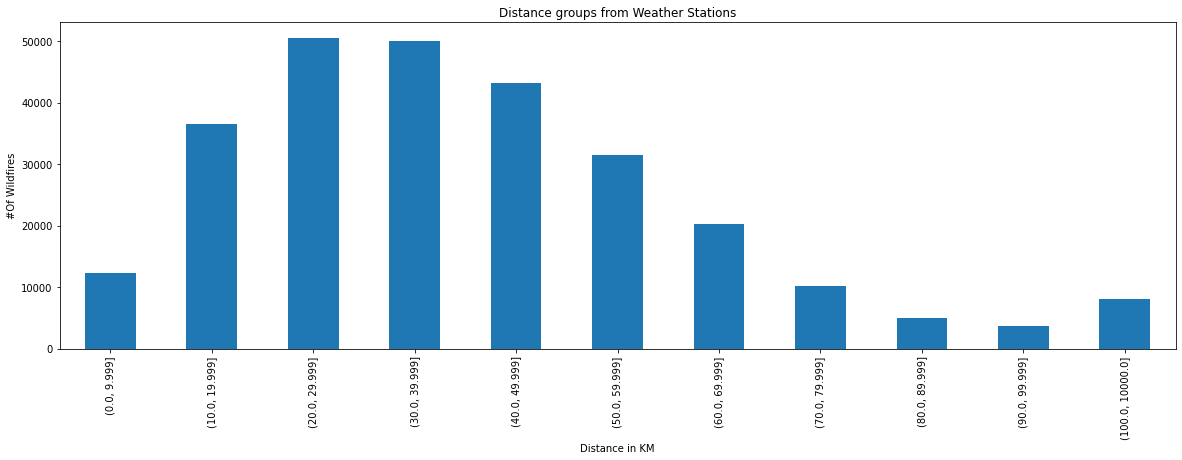

In [84]:
#first, round the distances column to the hundredth
wf_data['DISTANCE_TO_WS'] = wf_data['DISTANCE_TO_WS'].round(2)
bins = pd.IntervalIndex.from_tuples([(0,9.999), (10,19.999), (20,29.999), (30,39.999), (40,49.999), (50,59.999), (60,69.999), (70,79.999), (80,89.999), (90,99.999), (100,10000)])
groupby_ws_dist = wf_data.groupby(pd.cut(wf_data['DISTANCE_TO_WS'], bins=bins, 
    labels=['0 - 10', '10 - 20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90', '100'])).size()
print(groupby_ws_dist)

display(groupby_ws_dist.plot.bar(title = 'Distance groups from Weather Stations', figsize = (20,6), xlabel='Distance in KM', ylabel='#Of Wildfires'))

In [83]:
print(groupby_ws_dist.sum() == len(wf_data.index))
print('Sum of records in distance groupby: ',groupby_ws_dist.sum())
print('Length of wf data: ', len(wf_data.index))
sum_zero_forty = groupby_ws_dist.iloc[0:3].sum()
sum_zero_fifty = groupby_ws_dist.iloc[0:4].sum()
print('# Of Fires Under 40km from Weather Station: ', sum_zero_forty)
print('# Of Fires Under 50km from Weather Station: ', sum_zero_fifty)
print('% Fires under 50km from weather station: ', round(sum_zero_fifty / len(wf_data.index) * 100, 2))

False
Sum of records in distance groupby:  271140
Length of wf data:  271421
# Of Fires Under 40km from Weather Station:  99375
# Of Fires Under 50km from Weather Station:  149437
% Fires under 50km from weather station:  55.06


### So a little more the half of the Fire Origin Points are less than 50km from the closest weather station.
In reality, weather readings > 30km radius from a point can vary quite a bit. Especially when you factor in terrain, topography, and other factors in areas where wildfires typically occur.
For the purposes of this project we may go with this for now. But I may explore other spatial interpolation techniques like averaging readings from the 3 closest stations or Inverse Distance weighting. It would actually be a pretty cool add on to train and test some ML algos to predict weather at a given point.

There are a suprising number of fires over 100km from a weather station though. Lets sample that and explore.

In [87]:
greater_hundo = wf_data.loc[wf_data['DISTANCE_TO_WS'] > 100]
display(greater_hundo.head())
display(greater_hundo.tail())

,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DISTANCE_TO_WS
21,285,USTXTXF,National Forests And Grasslands In Texas,CEMETERY,TX,31.312500,-94.270833,2005,2005-01-25,1830,5.0,Debris Burning,2005-01-25,2222,55.0,C,USC00415618,130.96
22,288,USTXTXF,National Forests And Grasslands In Texas,ENON CEMETARY,TX,31.354167,-95.085278,2005,2005-04-07,1800,1.0,Lightning,2005-04-08,1550,55.0,C,USC00415869,132.66
23,300,USTXTXF,National Forests And Grasslands In Texas,RJ HERO,TX,31.436667,-95.150556,2005,2005-05-20,1330,7.0,Arson,2005-05-20,1415,16.0,C,USC00415869,124.78
209,2658,USNVHTF,Humboldt-Toiyabe National Forest,BELMONT,NV,38.583333,-116.650000,2005,2005-07-16,1131,1.0,Lightning,2005-07-16,1546,16.0,C,USC00260507,107.40
309,3436,USMNSUF,Superior National Forest,ALPINE LAKE,MN,48.140000,-90.967778,2005,2005-08-06,1245,1.0,Lightning,2005-08-08,0800,1335.0,F,USC00218419,134.48


,OBJECTID,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,FIRE_NAME,STATE,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,WEATHER_STATION,DISTANCE_TO_WS
270799,1869759,USHICNTY,Hawaii Counties,None,HI,20.052723,-155.400726,2006,2006-01-18,None,13.0,Missing/Undefined,None,None,20.0,C,USC00043161,3710.51
270800,1869765,USHICNTY,Hawaii Counties,None,HI,20.046820,-155.383255,2004,2004-09-03,None,13.0,Missing/Undefined,None,None,12.0,C,USC00043161,3709.61
270801,1869770,USHINPS,National Parks in Hawaii,None,HI,19.265301,-155.311707,2009,2009-06-02,None,13.0,Missing/Undefined,None,None,103.0,D,USC00043161,3763.50
270802,1869771,USHINPS,National Parks in Hawaii,None,HI,19.265301,-155.311707,2011,2011-05-19,None,13.0,Missing/Undefined,None,None,150.0,D,USC00043161,3763.50
270803,1869772,USHIHIS,State of Hawaii,None,HI,19.999340,-155.298584,2008,2008-09-12,None,13.0,Missing/Undefined,None,None,150.0,D,USC00043161,3706.69


STATE
AK    2835
AR     105
AZ      22
CA      57
CO      93
FL      24
HI     544
ID      45
LA     375
ME       6
MI      41
MN      27
MT      34
ND     210
NE       1
NM     110
NV     335
OR     128
SD       1
TX    2910
UT       3
WY      81
dtype: int64

<AxesSubplot:title={'center':'Fires > 100km from WS By State'}, xlabel='State', ylabel='# Of Wildfires'>

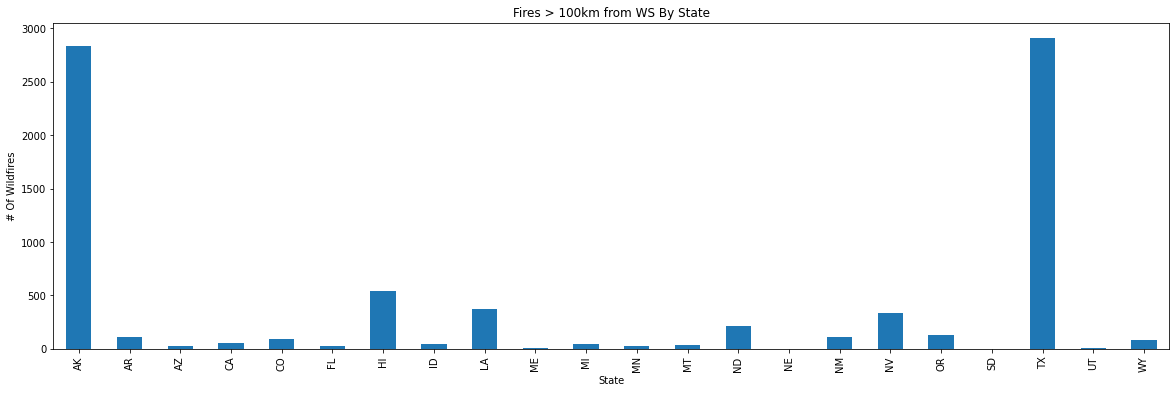

In [90]:
groupby_hundo_state = greater_hundo.groupby('STATE').size()

display(groupby_hundo_state)
groupby_hundo_state.plot.bar(title='Fires > 100km from WS By State', figsize = (20,6), xlabel='State', ylabel='# Of Wildfires')

#### It makes sense that Alaska has one of the highest quantities of remote fires, but I'm suprised to see texas with more fires > 100km from a weather station than Alaska. However the distribution of those distances in Texas could potentially be mostly between 100-150km. Alaskan wildfires could very well average > 1000km from weather stations. Lets dig a little deeper. 

In [120]:
groupby_gh_dtows_mean = greater_hundo.groupby('STATE', as_index=False)['DISTANCE_TO_WS'].mean()
groupby_gh_dtows_med = greater_hundo.groupby('STATE', as_index=False)['DISTANCE_TO_WS'].median()
#combine into 1 data frame for easier viewing
groupby_gh_dtows_mean = groupby_gh_dtows_mean.rename(columns={'DISTANCE_TO_WS': 'Mean_Distance'})
groupby_gh_dtows_med = groupby_gh_dtows_med.rename(columns={'DISTANCE_TO_WS': 'Median_Distance'})
dtows_combined = groupby_gh_dtows_mean
dtows_combined['Median_Distance'] = groupby_gh_dtows_med['Median_Distance']
dtows_combined['state'] = groupby_gh_dtows_med['STATE']
print(f'{Fore.GREEN}{Style.BRIGHT}Mean & Median Distance from Weather Station By State:')
display(dtows_combined)

Mean & Median Distance from Weather Station By State:


,STATE,Mean_Distance,Median_Distance,state
0,AK,2469.395799,2470.290,AK
1,AR,103.134476,102.560,AR
2,AZ,105.493636,104.205,AZ
3,CA,111.795614,110.340,CA
4,CO,106.937204,106.760,CO
5,FL,102.608333,102.820,FL
6,HI,3796.149099,3810.855,HI
7,ID,115.563111,116.840,ID
8,LA,103.876400,102.970,LA
9,ME,117.318333,117.020,ME


### Hmm... Just as I expected, 
Texas Wildfires have a mean distance of 118km and median distance of 116km from a weather station. Looking at the rest of the states, there are no major swings between mean and median so I'll have to consider that distances are pretty evenly distributed with no major outliers.

What these states with higher average distances means for using weather data in prediction models, I'm not quite sure yet. Still thinking about predicting weather for uknown points, but training on weather observations from the three closest stations. I wonder how a high success weather prediction model would assist in predicting causes and severeties of Wildfires.

Take a look at Hawaii though. Whats the deal there? There must be no Hawaiian weather stations in the ws_data dataframe. Lets look...

In [122]:
hi_weather_stations = ws_data[ws_data['state'] == 'HI']

display(hi_weather_stations)

,stationid,latitude,longitude,elevation,state,name,gsn,hcn,wmoid


### Nope, No weather stations in Hawaii, which seems a little odd. I will have to consider dropping Hawaiian fire data when I get to modeling.
#### Lets keep going with the more general exploration of the WF dataset

## Macro View:
### Number of Fires by Year
### Most common Causes
### Quantifying Severity with available variables

<AxesSubplot:title={'center':'Fires By Year'}, ylabel='Year'>

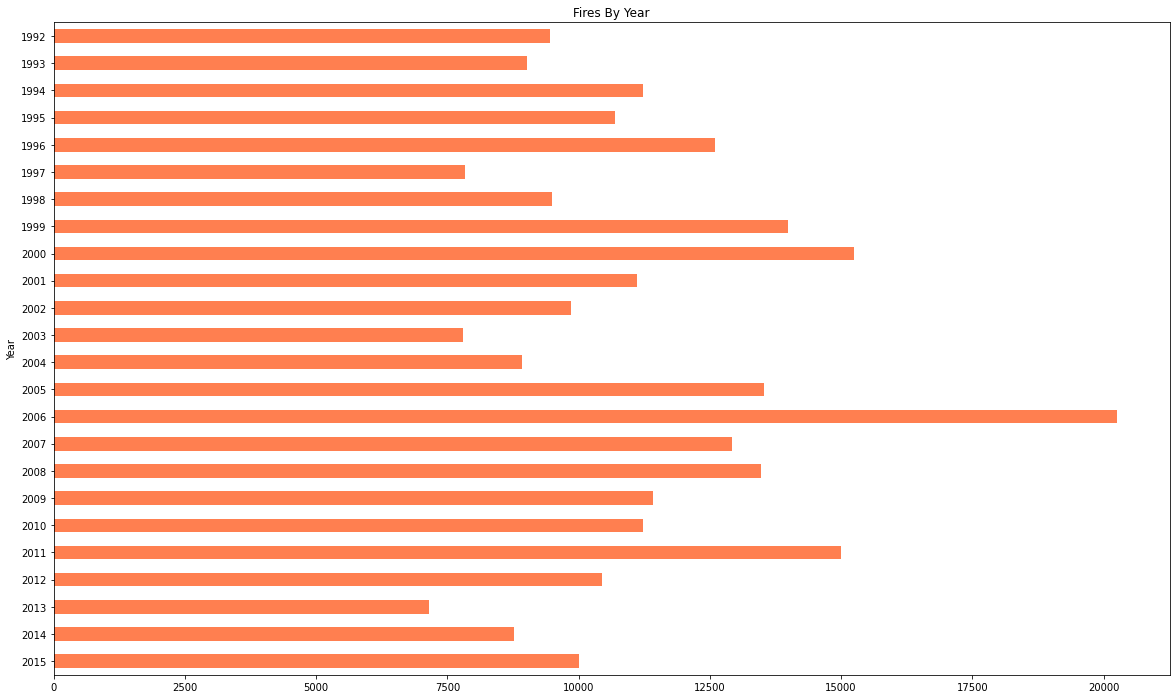

In [205]:
groupby_year = wf_data.groupby('FIRE_YEAR').size().sort_index(ascending=False)
groupby_year.plot.barh(title='Fires By Year', figsize = (20,12), xlabel='Year', color='coral')

In [159]:
# Check to see if 2015 has a complete record
# make sure dates columns are correct data type
wf_data['DISCOVERY_DATE'] = pd.to_datetime(wf_data['DISCOVERY_DATE'], errors='coerce')
wf_data['CONT_DATE'] = pd.to_datetime(wf_data['CONT_DATE'], errors='coerce')
fire_year_2015 = wf_data[wf_data['FIRE_YEAR'] == 2015].groupby(by=[wf_data['DISCOVERY_DATE'].dt.strftime('%B')]).size()
print(fire_year_2015)

DISCOVERY_DATE
April        1016
August       1093
December      153
February     1199
January       730
July          823
June          780
March        1766
May           497
November      485
October       864
September     605
dtype: int64


### 2015 has fires records for all 12 months.

### It's pretty safe to say that there is seasonality in wildfire, but let's visualize that.

Total count of Records == Sum Of Groups:  True


<AxesSubplot:title={'center':'Fire Occurrences By Month'}, xlabel='Month', ylabel='Fires Reported'>

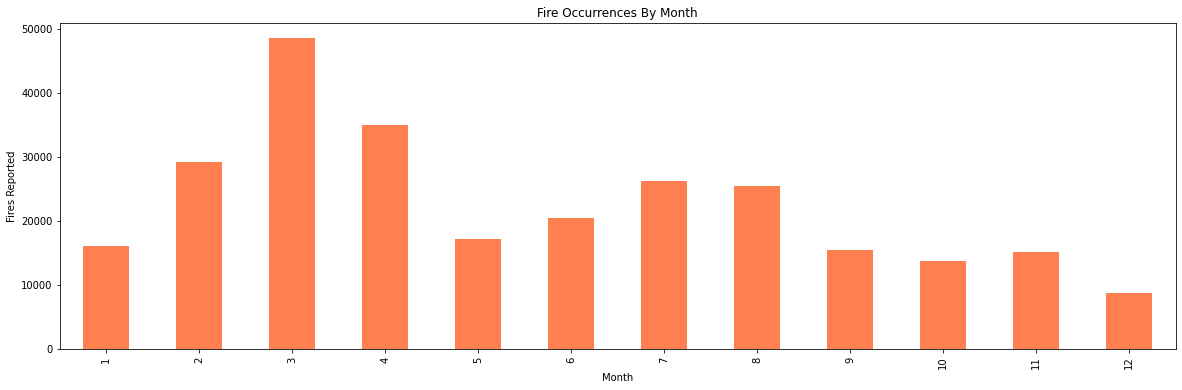

In [200]:
groupby_month_count = wf_data.groupby([wf_data['DISCOVERY_DATE'].dt.month]).size()
print(f'{Fore.GREEN}{Style.BRIGHT}Total count of Records == Sum Of Groups: ', groupby_month_count.sum() == len(wf_data.index))
groupby_month_count.plot.bar(title='Fire Occurrences By Month', figsize = (20,6), xlabel='Month', ylabel='Fires Reported', color='coral')

### Another suprise. February, March, and April have the most reported Wildfire events. while June, July, and August spike much more subtly.

<AxesSubplot:title={'center':'Acres Burned By Month'}, xlabel='Month', ylabel='Acres'>

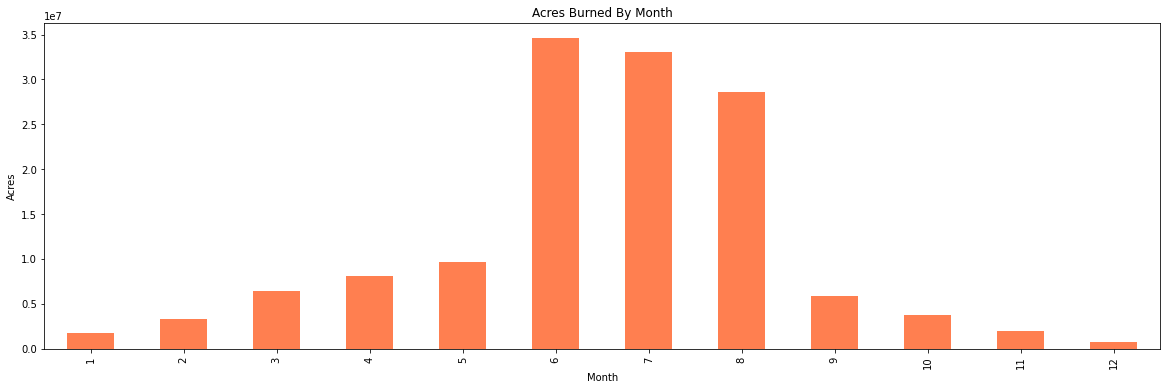

In [203]:
groupby_month_size = wf_data.groupby([wf_data['DISCOVERY_DATE'].dt.month])['FIRE_SIZE'].sum()
groupby_month_size.plot.bar(title='Acres Burned By Month', figsize = (20,6), xlabel='Month', ylabel='Acres', color='coral')

### Although the late winter/spring month win in terms of quantity of fire events, the Summer months leap ahead massively in terms of total acres burned

I generally tend to think of fire season as June - September, however the plot above showing quantity of fires by month has me intrigued. I want to look a little further at that.

My hypothesis is that the states that see the most fires in terms of quantity of unique events, are more prone to smaller more frequent fires during Feb - April. I also assume that fire frequency is regional, or seasonally specific to a region or climate.

MONTH  STATE
1      AK       432.700000
       AL        33.865948
       AR        55.216453
       AZ        86.148214
       CA       207.329365
                   ...    
12     UT        76.250000
       VA       130.958823
       WI        50.889333
       WV        81.535948
       WY        69.888889
Name: FIRE_SIZE, Length: 562, dtype: float64

<AxesSubplot:title={'center':'Mean Fire Size by Month & State'}, xlabel='Month', ylabel='Acres'>

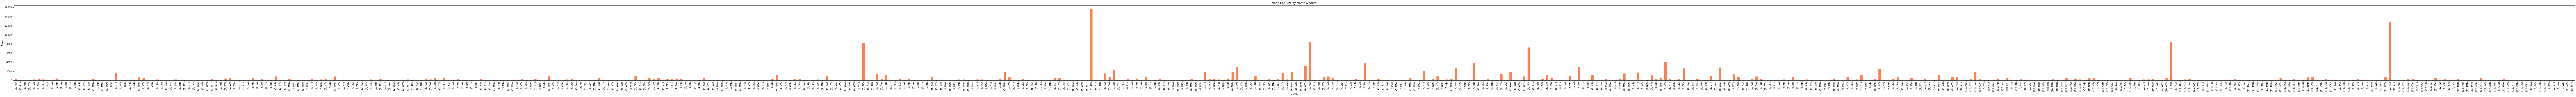

In [219]:
groupby_month_state = wf_data.groupby([wf_data['DISCOVERY_DATE'].dt.month, 'STATE'])['FIRE_SIZE'].mean()
#check the output for order
groupby_month_state = groupby_month_state.rename_axis(index={'DISCOVERY_DATE': 'MONTH'})
groupby_month_state = groupby_month_state.sort_index()
groupby_month_state.plot.bar(title='Mean Fire Size by Month & State', figsize = (200,6), xlabel='Month', ylabel='Acres', color='coral')

## States With Most Wildfires Over 10 Acres

How many states have wildfire records: 50


<AxesSubplot:title={'center':'# Fires Reported By State'}, ylabel='Fires Reported'>

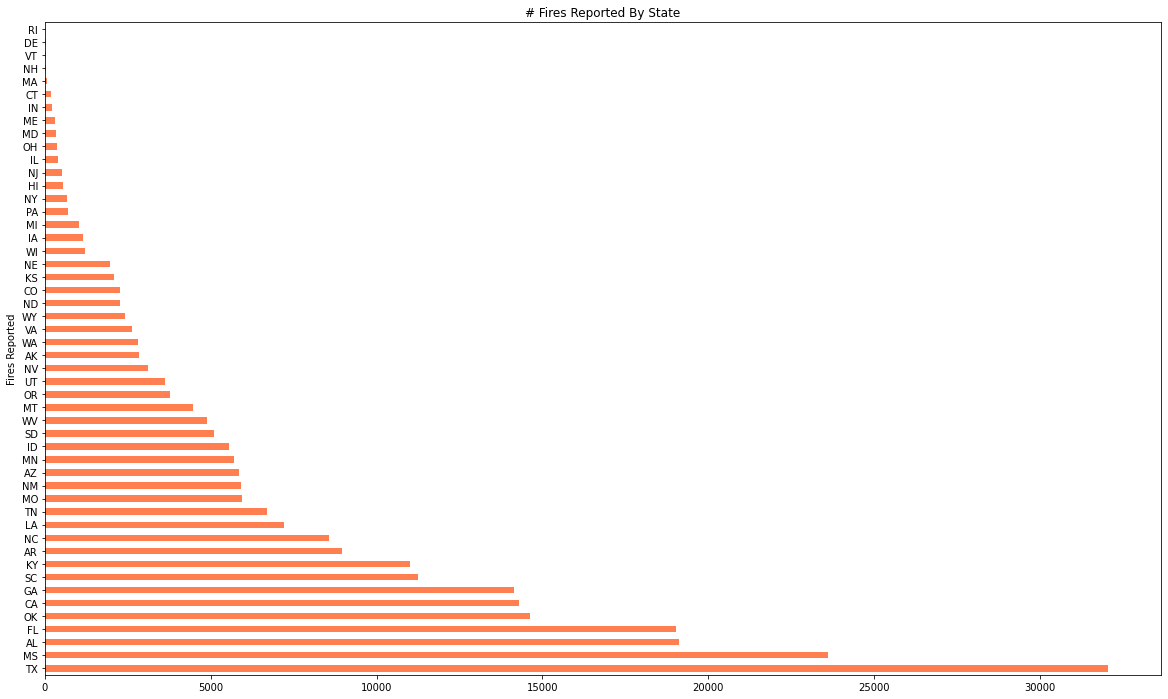

In [135]:
groupby_state = wf_data.groupby('STATE').size().sort_values(ascending=False)
print(f'How many states have wildfire records: {len(groupby_state)}')
groupby_state.plot.barh(title='# Fires Reported By State', figsize = (20,12), xlabel='Fires Reported', ylabel='State', color='coral')

### I have to say I'm suprised to see some of the states in the top 10.
States like Texas and California makes sense because of climates and land area, but I'm suprised to see southern states with more humid climates like MS, AL, FL and GA. I'll have to look at most prominent causes by state and other quantifiable variables that allude to severity, like acres burned and time to containment. I'm going to go with my gut and predict that southern states like MS, AL, FL, and GA on average see smaller burn areas with a higher percentage of manmade causes.

It's also possible that more sparsely populis states in the west have a higher percentage of fires that go unreported or die out naturally before detection.

### More on that later, though. First lets get a better idea of Seasonal swings by state/region 

## Fires By Cause

<AxesSubplot:>

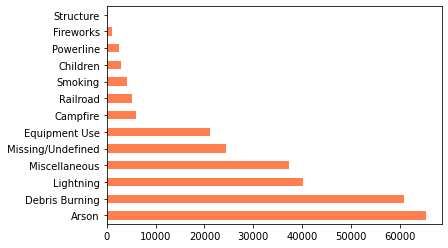

In [145]:
display(wf_data['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh', color='coral'))